**Importing all the important libraries**

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from datasets import load_dataset, Dataset
from sklearn.ensemble import  RandomForestClassifier
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from mediapipe_handler import MediaPipeHandler
from get_work_out_labels import add_workout_label_back, merge_similar_workouts
import seaborn as sns
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE


/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Workflow**
1. Loading Training and Testing Datasets
2. Add Label string values
3. Looking at workout distributions
4. Preprocessing
5. Feature Engineering
6. Train Random Forest with hyperparameters [with and without feature engineering]
7. Train Neural Network with hyperparameters [with and without feature engineering]
8. Train SVM with hyperparameters [with and without feature engineering]
9. Compare model performance in terms of SPEED,ACCURACY,PERCISION,RECALL,F1-SCORE
10. Do the same process but with SMOTE to handle imbalance classes, then compare accuracy

**1. Loading Training and Testing Datasets**

In [2]:
mediapipe_model = MediaPipeHandler()

training_dataset=mediapipe_model.read_csv_to_pd(os.getcwd() + "/../data/train_new.csv")[:60000]
testing_dataset=mediapipe_model.read_csv_to_pd(os.getcwd() + "/../data/test_new.csv")
validation_dataset=mediapipe_model.read_csv_to_pd(os.getcwd() + "/../data/validation_new.csv")


current OS working directory is /Users/yasinetawfeek/Developer/DesD_AI_pathway/AI/app


I0000 00:00:1745794493.833046 4425073 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1745794493.887326 4425359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745794493.913037 4425364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [3]:
training_dataset

,Unnamed: 0,image,label,muscle group,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle
0,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,15,6,"[0.5484301, 0.49004129, -0.43226662]","[0.37600738, 0.51022822, -0.37942311]","[0.56280234, 0.68481307, -0.44957601]","[0.36387506, 0.69915706, -0.41347653]","[0.55147046, 0.88886571, -0.53499579]","[0.36579115, 0.87213809, -0.52053868]","[0.50563251, 0.72930047, -0.01256276]","[0.41844976, 0.75091356, 0.00929317]","[0.53790456, 0.97131133, 0.06646194]","[0.41987459, 0.96974429, -0.0166773]","[0.51163906, 0.9699108, 0.46864548]","[0.40170884, 0.97035861, 0.42597219]"
1,1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,16,4,"[0.24912152, 0.35584787, -0.51078904]","[0.15138835, 0.35291201, -0.2042595]","[0.37174187, 0.63287771, -0.52235281]","[0.24799727, 0.62684762, -0.15082791]","[0.37931541, 0.92076492, -0.53436857]","[0.23846388, 0.82453698, -0.22998846]","[0.34708418, 0.73124863, -0.09511818]","[0.27085277, 0.68803418, 0.10734746]","[0.30053854, 0.9172104, 0.24736579]","[0.2827403, 0.85448642, 0.47173723]","[0.26930132, 0.87905887, 0.73818749]","[0.25489525, 0.86295189, 0.87710514]"
2,2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,7,"[0.53350778, 0.38277617, 0.10339462]","[0.49622032, 0.40925051, -0.33102048]","[0.50711787, 0.4804793, 0.13848641]","[0.49764794, 0.53821802, -0.38787264]","[0.50357372, 0.57651955, 0.04592444]","[0.49598753, 0.64910597, -0.37136137]","[0.42295463, 0.54345038, 0.122346]","[0.40116915, 0.5381611, -0.1400498]","[0.51171586, 0.62744528, 0.24819838]","[0.45836467, 0.67322558, -0.2832658]","[0.47369909, 0.76988298, 0.37833557]","[0.43934485, 0.81914365, -0.10054879]"
3,3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,4,3,"[0.36701075, 0.3617845, 0.26839375]","[0.2805858, 0.36825189, 0.01247021]","[0.47051519, 0.45498389, 0.22723082]","[0.30642483, 0.52219439, -0.23609887]","[0.56970313, 0.49077906, 0.0337323]","[0.36985027, 0.56225231, -0.50007813]","[0.51236174, 0.58385521, 0.09089002]","[0.44266266, 0.61836749, -0.10174175]","[0.68244904, 0.45012978, -0.1227973]","[0.57340004, 0.47867663, -0.41728527]","[0.71173745, 0.75661421, -0.15498058]","[0.63487416, 0.8034286, -0.39761847]"
4,4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,2,"[0.69525528, 0.52786577, 0.04467355]","[0.62983799, 0.50277424, 0.56467396]","[0.70026263, 0.41725649, -0.15214185]","[0.54976642, 0.42280561, 0.59385026]","[0.69298444, 0.28250597, -0.16880389]","[0.55097508, 0.29683715, 0.49996668]","[0.47567302, 0.55650461, -0.14830561]","[0.44508341, 0.54160005, 0.14784944]","[0.34407347, 0.57092351, -0.47356901]","[0.23333503, 0.551884, -0.08928732]","[0.34045973, 0.8297655, -0.54246277]","[0.22263443, 0.79544785, -0.11700201]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,59995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,12,4,"[0.5607537, 0.59736198, -0.08172052]","[0.46311292, 0.58950795, -0.09699694]","[0.57141531, 0.68693739, -0.26343989]","[0.4755103, 0.69314969, -0.28200915]","[0.54427281, 0.62049931, -0.51333641]","[0.51712665, 0.63098703, -0.49608886]","[0.54845285, 0.74585211, -0.00177928]","[0.49879459, 0.74754411, 0.00143051]","[0.54881853, 0.7018019, -0.40173689]","[0.49933311, 0.69968635, -0.41440156]","[0.51512643, 0.77993128, -0.66303476]","[0.50216792, 0.80154257, -0.66774256]"
59996,59996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,2,"[0.58438814, 0.1523402, 0.02845847]","[0.50249344, 0.15794413, 0.01307037]","[0.63054589, 0.18968052, -0.02151452]","[0.4783206, 0.24079515, -0.07508612]","[0.61960882, 0.195611, -0.23893635]","[0.4701487, 0.27521955, -0.27208936]","[0.57552093, 0.37169358, 0.0049757]","[0.5205523, 0.37014454, 0.00208476]","[0.59707107, 0.50783258, -0.11238497]","[0.547678, 0.4993855, -0.16025431]","[0.63279877, 0.65335463, -0.03029437]","[0.58394238, 0.62357199, -0.01613212]"
59997,59997,<PIL.JpegImagePlugin.Jp

In [4]:
training_dataset['left_ankle']

0          [0.51163906, 0.9699108, 0.46864548]
1         [0.26930132, 0.87905887, 0.73818749]
2         [0.47369909, 0.76988298, 0.37833557]
3        [0.71173745, 0.75661421, -0.15498058]
4         [0.34045973, 0.8297655, -0.54246277]
                         ...                  
59995    [0.51512643, 0.77993128, -0.66303476]
59996    [0.63279877, 0.65335463, -0.03029437]
59997    [0.63163616, 0.64068311, -0.04105918]
59998    [0.27005125, 0.70960766, -0.37314523]
59999        [0.84667656, 0.69735775, 0.35135]
Name: left_ankle, Length: 60000, dtype: object

**2. Add Label String Values**

In [5]:
training_dataset['WorkoutLabel']=training_dataset.apply(lambda x: add_workout_label_back(x['label']) ,axis=1)


**3. Looking at Workout Distribution**

In [6]:
Workout_labels=training_dataset['WorkoutLabel'].unique()

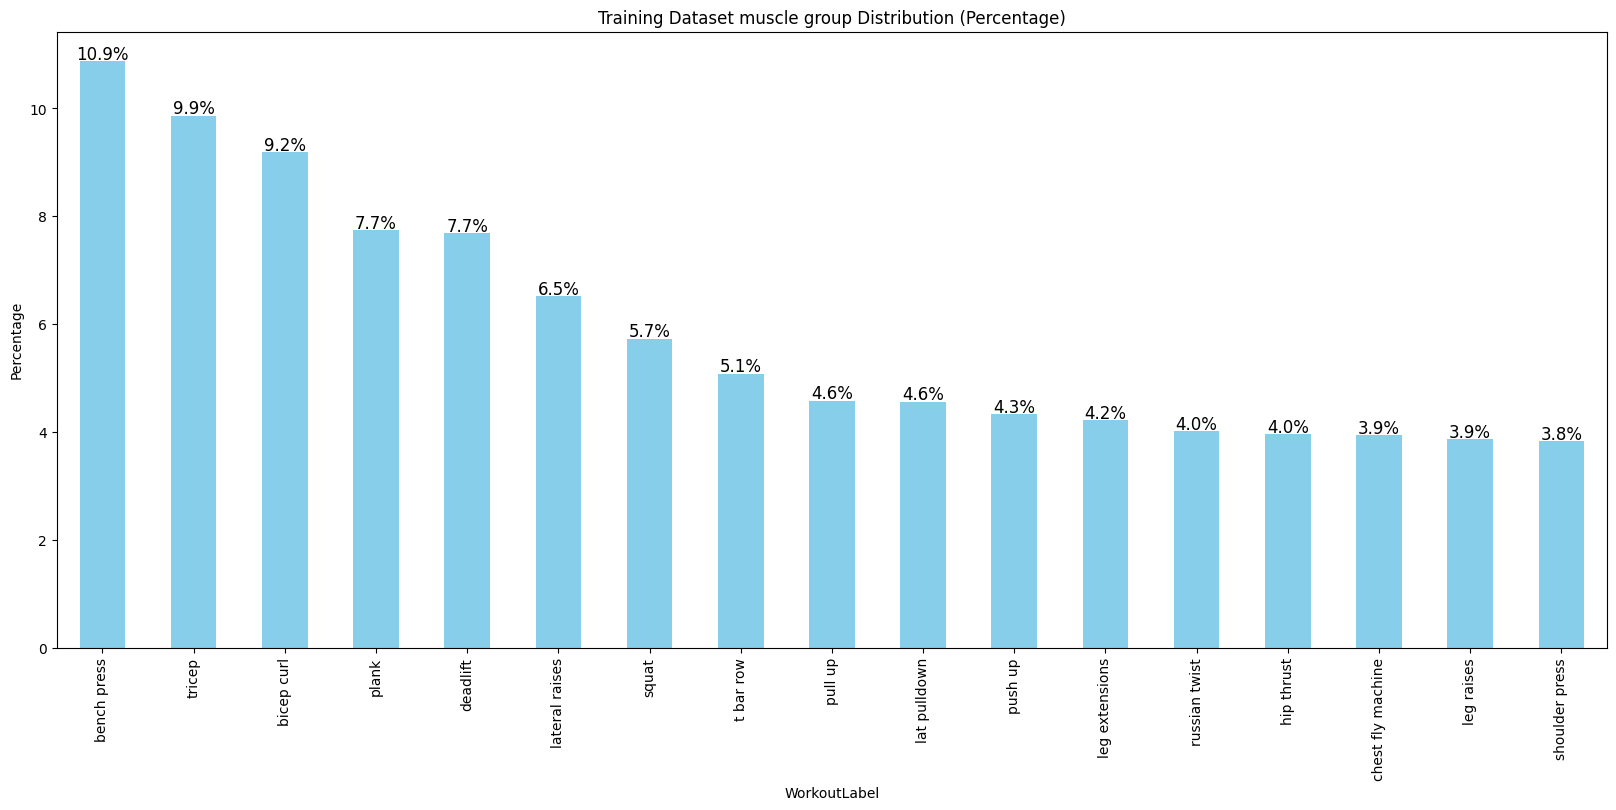

(60000, 17)


In [7]:
def display_class_distribution(classes):    
    plt.figure(figsize=(20,8))
    value_counts = classes.value_counts()
    percentages = value_counts / value_counts.sum() * 100

    # Plot
    ax = percentages.plot(kind='bar', color='skyblue')

    # Add percentage text on each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    plt.title('Training Dataset muscle group Distribution (Percentage)')
    plt.ylabel('Percentage')
    plt.show()
display_class_distribution(training_dataset['WorkoutLabel'])
print(training_dataset.shape)

**4. Preprocessing**

**We have to make sure that we get right of Unamed 0: column, as it just contains numerical index not very useful, might lead to overfitting if it is left**
- Get rid of Unnamed 0:
- Get rid of image
- Get rid of muscle group
- split each feature into x,y,z components, then remove that original feature


In [8]:
"""
Removes original feature and splits it into x,y,z components

"""
def Preprocess_data(dataframe,columns_to_flatten):
    final_df=dataframe.copy()
    # Expanding each column into 3 separate columns (x, y, z) and appending it to the final dataframe.
    for column in columns_to_flatten:
        # print(np.vstack(dataframe[column]).astype(float))
        expanded_df=pd.DataFrame(np.vstack(dataframe[column]).astype(float), 
                           columns=[column+'_x', column+'_y', column+'_z'],
                           index=dataframe.index)
        new_df = pd.concat([dataframe.drop(column, axis=1), expanded_df], axis=1)
        for new_column in new_df.columns:
            final_df[new_column] = new_df[new_column]

    return final_df.drop(columns=columns_to_flatten,axis=1)

"""
Splits dataset into X_train,y_train or X_test,y_test, if you give it training dataset then X_train and y_train

"""
def Return_X_y(dataframe,columns_to_delete):
    X=dataframe.drop(columns=columns_to_delete)
    y=dataframe['label']
    return X,y

In [9]:
features_to_split=['left_shoulder',
       'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist',
       'right_wrist', 'left_hip', 'right_hip', 'left_knee',
       'right_knee', 'left_ankle', 'right_ankle']

training_dataset_preprocessed=Preprocess_data(training_dataset,features_to_split)
X_train, y_train = Return_X_y(training_dataset_preprocessed,['label','muscle group','WorkoutLabel','image','Unnamed: 0'])


testing_dataset_preprocessed=Preprocess_data(testing_dataset,features_to_split)
X_test, y_test = Return_X_y(testing_dataset_preprocessed,['label','muscle group','image','Unnamed: 0'])

validation_dataset_preprocessed=Preprocess_data(validation_dataset,features_to_split)
X_validation, y_validation = Return_X_y(validation_dataset_preprocessed,['label','muscle group','image','Unnamed: 0'])

In [10]:
smote = SMOTE(random_state=42)
print(X_train)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test)
X_validation, y_validation = smote.fit_resample(X_validation, y_validation)

       left_shoulder_x  left_shoulder_y  left_shoulder_z  right_shoulder_x  \
0             0.548430         0.490041        -0.432267          0.376007   
1             0.249122         0.355848        -0.510789          0.151388   
2             0.533508         0.382776         0.103395          0.496220   
3             0.367011         0.361785         0.268394          0.280586   
4             0.695255         0.527866         0.044674          0.629838   
...                ...              ...              ...               ...   
59995         0.560754         0.597362        -0.081721          0.463113   
59996         0.584388         0.152340         0.028458          0.502493   
59997         0.644905         0.492385        -0.514265          0.536628   
59998         0.710935         0.310191         0.241379          0.576519   
59999         0.363461         0.329704        -0.425629          0.272295   

       right_shoulder_y  right_shoulder_z  left_elbow_x  left_e

In [11]:
print("X_train Shape",X_train.shape)

print("y_train Shape",y_train.shape)

print("X_test Shape",X_test.shape)

print("y_test Shape",y_test.shape)

X_train Shape (110959, 36)
y_train Shape (110959,)
X_test Shape (21726, 36)
y_test Shape (21726,)


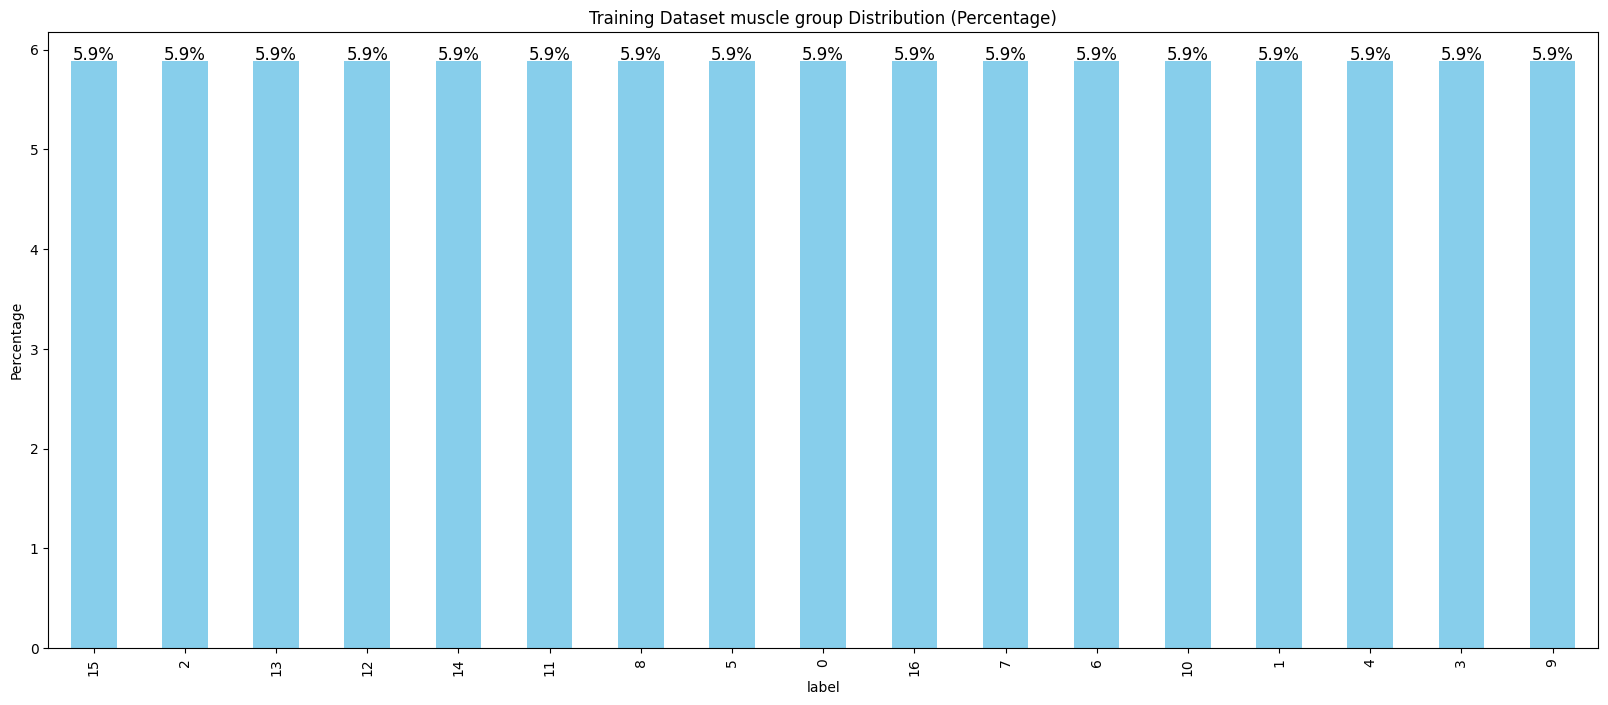

In [12]:
display_class_distribution(y_train)

**66 Features is all the features**

**5. Feature Engineering**

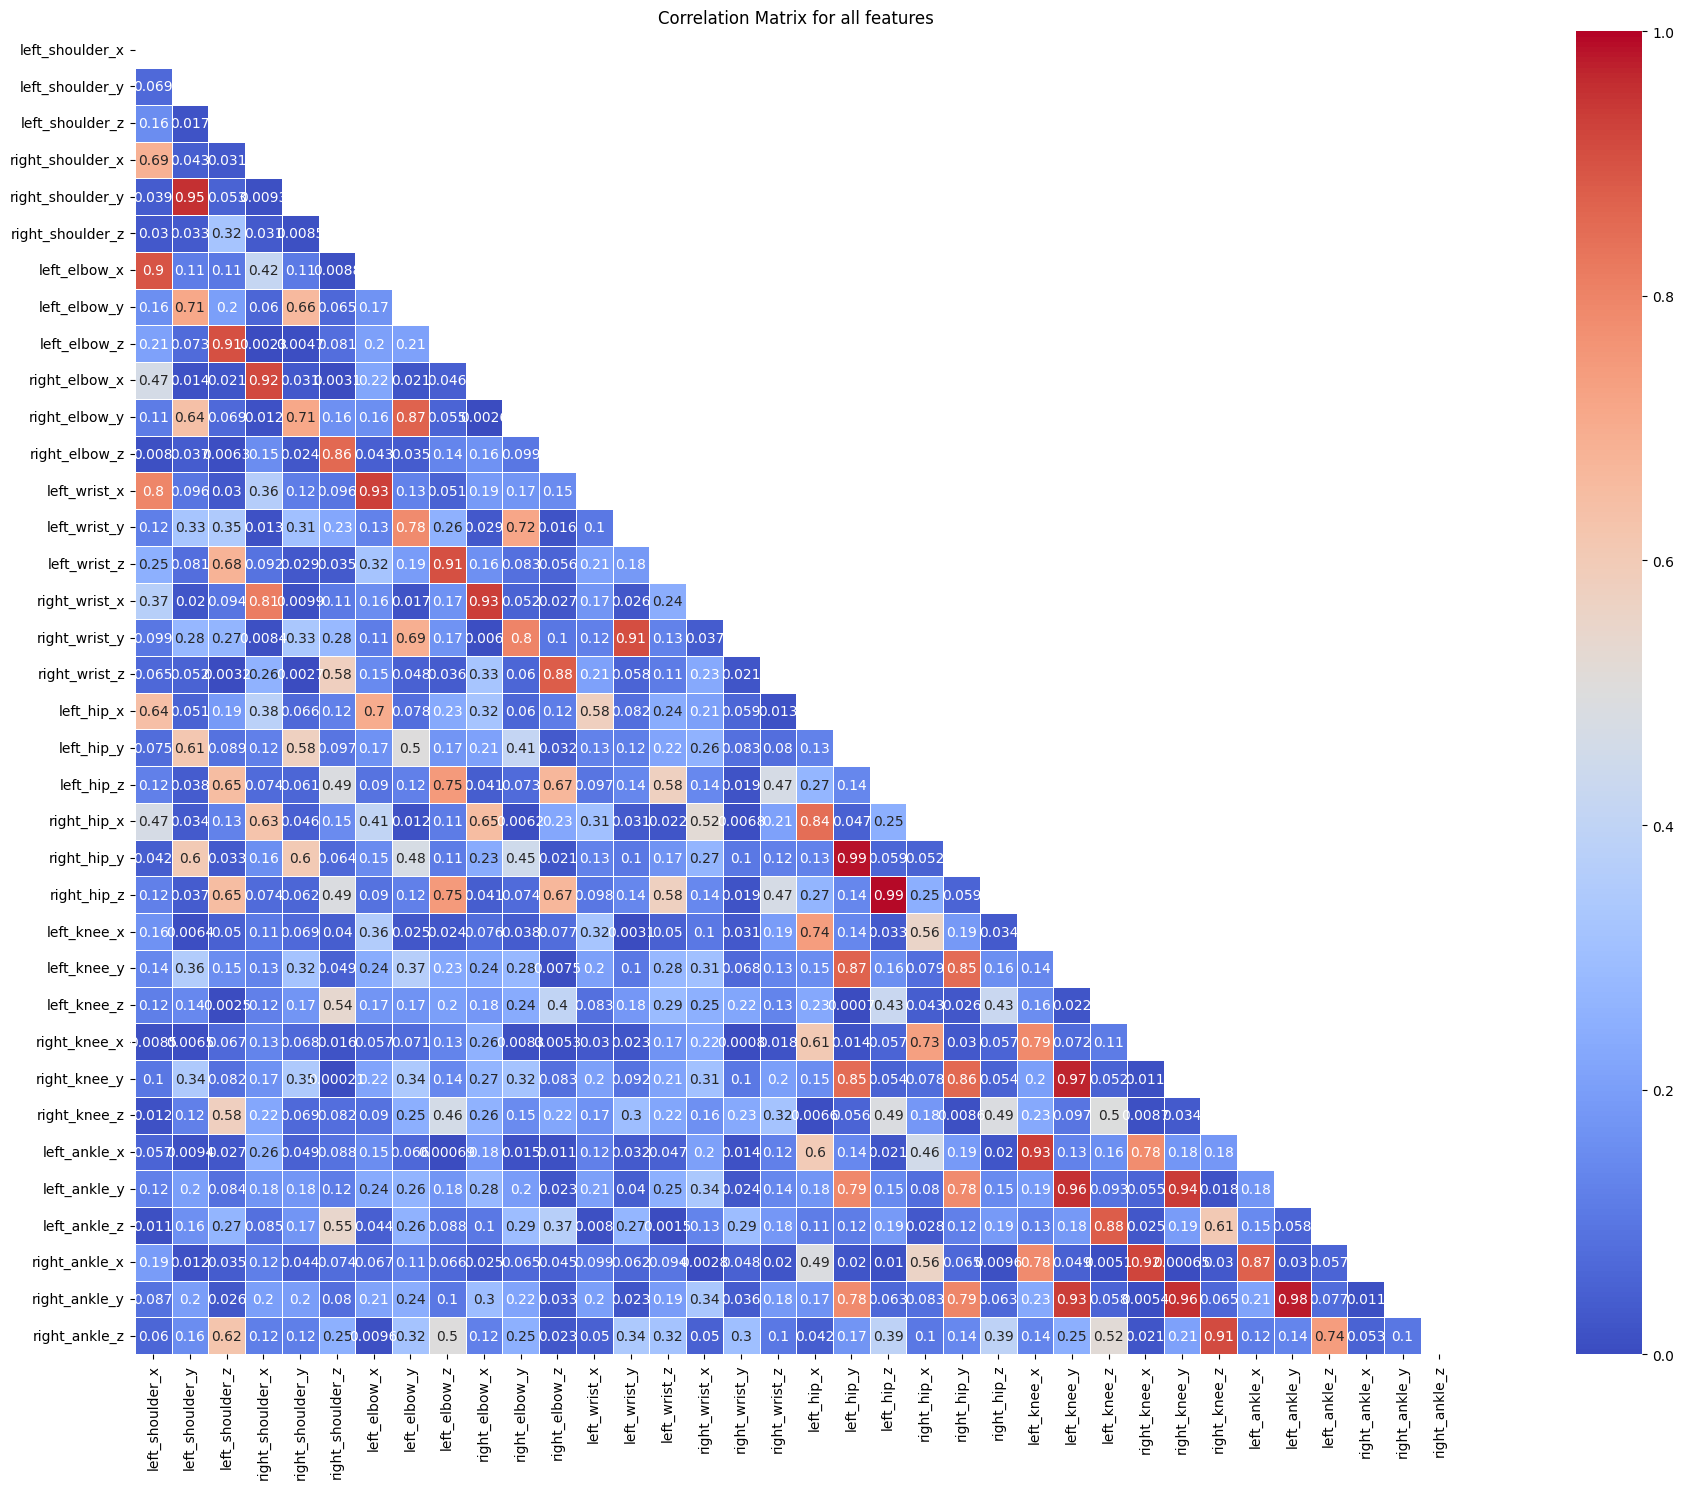

In [13]:
corr_matrix = X_train.corr().abs()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(24, 15))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', 
            vmax=1.0, vmin=0, center=0.5,
            square=True, linewidths=.5, annot=True).set(title='Correlation Matrix for all features')
plt.tight_layout()
plt.show()

**Features that are highly correlated , one of them should be removed**
- it is better to remove the one that is the least correlated with y_target

In [14]:
correlation_threshold = 0.8
columns_to_drop = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > correlation_threshold:
            columns_to_drop.append(corr_matrix.columns[j])
            print(f"High Correlation between {corr_matrix.columns[i]} and {corr_matrix.columns[j]} --> {corr_matrix.iloc[i, j]:.2f}")

columns_to_drop = list(set(columns_to_drop))
print(f"Columns to drop: {columns_to_drop}")
print(f"number of columns to drop: {len(columns_to_drop)}")

High Correlation between left_shoulder_x and left_elbow_x --> 0.90
High Correlation between left_shoulder_y and right_shoulder_y --> 0.95
High Correlation between left_shoulder_z and left_elbow_z --> 0.91
High Correlation between right_shoulder_x and right_elbow_x --> 0.92
High Correlation between right_shoulder_x and right_wrist_x --> 0.81
High Correlation between right_shoulder_z and right_elbow_z --> 0.86
High Correlation between left_elbow_x and left_wrist_x --> 0.93
High Correlation between left_elbow_y and right_elbow_y --> 0.87
High Correlation between left_elbow_z and left_wrist_z --> 0.91
High Correlation between right_elbow_x and right_wrist_x --> 0.93
High Correlation between right_elbow_z and right_wrist_z --> 0.88
High Correlation between left_wrist_y and right_wrist_y --> 0.91
High Correlation between left_hip_x and right_hip_x --> 0.84
High Correlation between left_hip_y and right_hip_y --> 0.99
High Correlation between left_hip_y and left_knee_y --> 0.87
High Correlatio

In [15]:
print(f"Columns to drop: {columns_to_drop}")


Columns to drop: ['left_elbow_x', 'right_wrist_y', 'right_elbow_z', 'right_wrist_x', 'right_hip_x', 'left_ankle_x', 'left_ankle_z', 'right_elbow_x', 'left_wrist_z', 'right_wrist_z', 'left_elbow_z', 'left_wrist_x', 'right_hip_y', 'right_hip_z', 'right_knee_y', 'right_elbow_y', 'left_knee_y', 'left_ankle_y', 'right_ankle_x', 'right_ankle_z', 'right_shoulder_y', 'right_ankle_y']


**53 Columns to drop**

In [16]:
X_train_feature_eng=X_train.drop(columns=columns_to_drop)
X_test_feature_eng=X_test.drop(columns=columns_to_drop)

In [17]:
X_train_feature_eng

,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_z,left_elbow_y,left_wrist_y,left_hip_x,left_hip_y,left_hip_z,left_knee_x,left_knee_z,right_knee_x,right_knee_z
0,0.548430,0.490041,-0.432267,0.376007,-0.379423,0.684813,0.888866,0.505633,0.729300,-0.012563,0.537905,0.066462,0.419875,-0.016677
1,0.249122,0.355848,-0.510789,0.151388,-0.204260,0.632878,0.920765,0.347084,0.731249,-0.095118,0.300539,0.247366,0.282740,0.471737
2,0.533508,0.382776,0.103395,0.496220,-0.331020,0.480479,0.576520,0.422955,0.543450,0.122346,0.511716,0.248198,0.458365,-0.283266
3,0.367011,0.361785,0.268394,0.280586,0.012470,0.454984,0.490779,0.512362,0.583855,0.090890,0.682449,-0.122797,0.573400,-0.417285
4,0.695255,0.527866,0.044674,0.629838,0.564674,0.417256,0.282506,0.475673,0.556505,-0.148306,0.344073,-0.473569,0.233335,-0.089287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110954,0.319152,0.612397,-0.240911,0.246846,-0.792525,0.748563,0.908741,0.197321,0.883069,0.177090,0.261884,0.640134,0.115663,0.049513
110955,0.578614,0.261291,-0.136490,0.503983,0.250186,0.302987,0.418249,0.585143,0.496495,-0.115260,0.620321,-0.172544,0.605314,0.052344
110956,0.558541,0.343356,0.128315,0.518758,-0.292668,0.447456,0.566723,0.493590,0.609524,0.130805,0.453633,0.136263,0.410725,-0.244670
110957,0.516392,0.284661,-0.316267,0.403275,0.059500,0.347650,0.559708,0.651831,0.661609,-0.113669,0.773742,0.001843,0.684436,0.246128


In [18]:
X_train.columns

Index(['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z',
       'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'right_elbow_x',
       'right_elbow_y', 'right_elbow_z', 'left_wrist_x', 'left_wrist_y',
       'left_wrist_z', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z',
       'left_hip_x', 'left_hip_y', 'left_hip_z', 'right_hip_x', 'right_hip_y',
       'right_hip_z', 'left_knee_x', 'left_knee_y', 'left_knee_z',
       'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_ankle_x',
       'left_ankle_y', 'left_ankle_z', 'right_ankle_x', 'right_ankle_y',
       'right_ankle_z'],
      dtype='object')

In [19]:
X_train_feature_eng.columns

Index(['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'right_shoulder_x', 'right_shoulder_z', 'left_elbow_y', 'left_wrist_y',
       'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_knee_x', 'left_knee_z',
       'right_knee_x', 'right_knee_z'],
      dtype='object')

In [20]:
"""
This function takes both training_dataset
then it will show the result for each one of the models

1-Accuracy
2-Classification Report
3-Confusion Matrix
4-Precision, Recall, F1-Score
5-Time Taken to train
6-Features used to build the model

"""

def train_model(model,param_grid,X_train,y_train,X_test,y_test):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,  # 5-fold cross-validation
        n_jobs=-1,  # Use all available cores
        verbose=2,
        scoring='accuracy'
    )
    grid_search.fit(X_train,y_train)
    y_predictions=grid_search.predict(X_test)
    accuracy = accuracy_score(y_test,y_predictions)
    report = classification_report(y_test,y_predictions)
    confusion_matrix_values = confusion_matrix(y_test,y_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_values, annot=True, fmt='d', cmap='Blues', cbar=True, 
                xticklabels=Workout_labels,
                yticklabels=Workout_labels)

    # Add labels, title, and axis ticks
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')

    # Show the plot
    plt.show()
    print("Best Parameters:", grid_search.best_params_)
    print("Accuracy:", (accuracy*100),"%")
    print("Classification Report:\n", report)
    return grid_search.best_estimator_

**Random Forest**

In [21]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [20, 50, 100],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    # 'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}



**Random Forest with no feature engineering**

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=  18.4s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=  18.7s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=  18.9s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=50; total time=  18.5s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=50; total time=  18.7s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=50; total time=  18.8s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  36.8s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  37.1s
[CV] END criter

/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_split=10, n_estimators=50; total time=  18.6s
[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_split=10, n_estimators=50; total time=  18.4s
[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_split=10, n_estimators=50; total time=  18.2s
[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  36.6s
[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  37.0s
[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  37.2s
[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 1.2min
[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 1.2min
[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_s

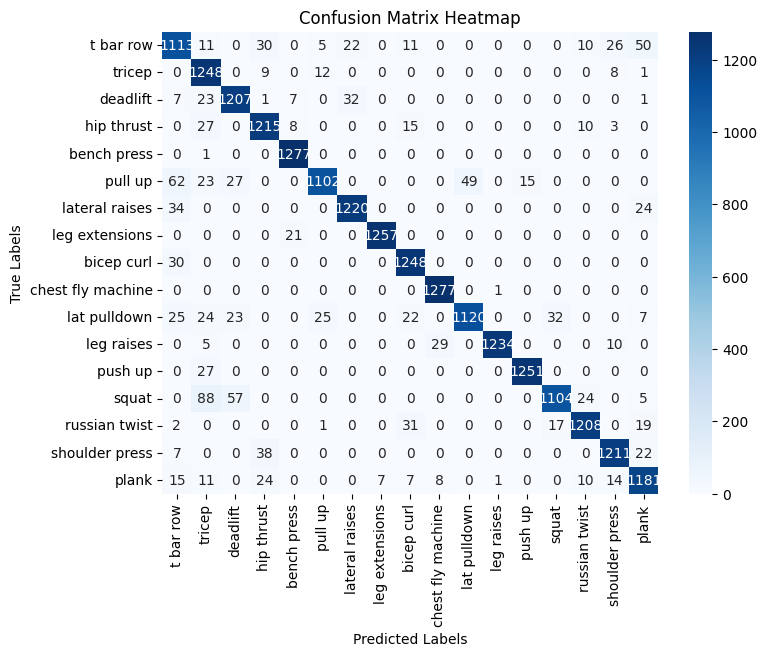

Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 94.23271656080271 %
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87      1278
           1       0.84      0.98      0.90      1278
           2       0.92      0.94      0.93      1278
           3       0.92      0.95      0.94      1278
           4       0.97      1.00      0.99      1278
           5       0.96      0.86      0.91      1278
           6       0.96      0.95      0.96      1278
           7       0.99      0.98      0.99      1278
           8       0.94      0.98      0.96      1278
           9       0.97      1.00      0.99      1278
          10       0.96      0.88      0.92      1278
          11       1.00      0.97      0.98      1278
          12       0.99      0.98      0.98      1278
          13       0.96      0.86      0.91      1278
        

In [22]:
random_tree_model = RandomForestClassifier(random_state=42)
rfc_model = train_model(random_tree_model,param_grid,X_train,y_train,X_test,y_test)
print(rfc_model.classes_)

In [26]:
with open(os.getcwd() + "/models/rfc_workout_classifier.pkl", 'wb') as f:
    print(type(rfc_model))
    pickle.dump(rfc_model, f)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [27]:
with open(os.getcwd() + "/models/rfc_workout_classifier.pkl", 'rb') as f:
    rfc_model = pickle.load(f)

**Random Forest with feature engineering**

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   9.6s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=50; total time=   9.7s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=50; total time=   9.7s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=50; total time=   9.8s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   9.9s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   9.9s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  19.3s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  19.5s
[CV] END criter

/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=2, n_estimators=200; total time=  40.6s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=10, n_estimators=100; total time=  20.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=10, n_estimators=100; total time=  19.8s
[CV] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=  10.3s
[CV] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=  10.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=10, n_estimators=100; total time=  20.3s
[CV] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   9.9s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=5, n_estimators=200; total time=  39.9s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_sp

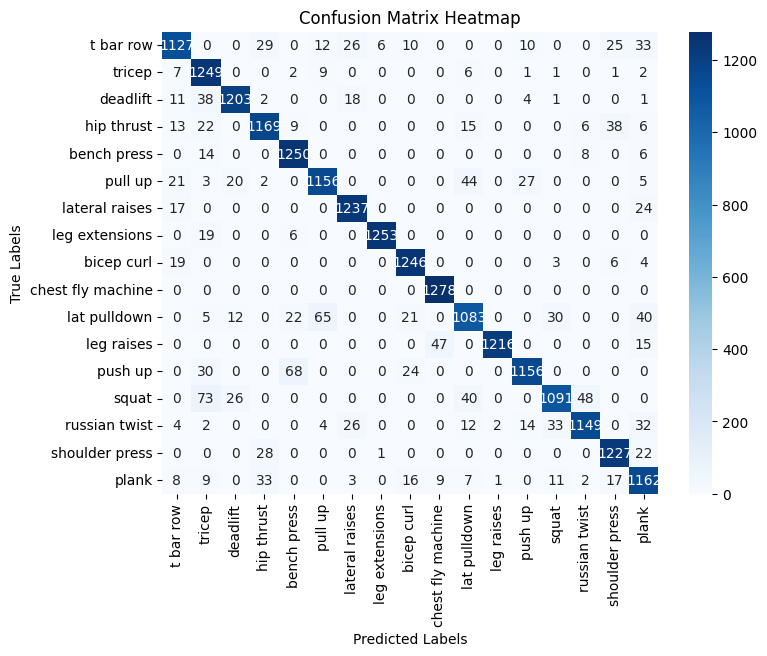

Best Parameters: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 93.21550216330664 %
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      1278
           1       0.85      0.98      0.91      1278
           2       0.95      0.94      0.95      1278
           3       0.93      0.91      0.92      1278
           4       0.92      0.98      0.95      1278
           5       0.93      0.90      0.92      1278
           6       0.94      0.97      0.96      1278
           7       0.99      0.98      0.99      1278
           8       0.95      0.97      0.96      1278
           9       0.96      1.00      0.98      1278
          10       0.90      0.85      0.87      1278
          11       1.00      0.95      0.97      1278
          12       0.95      0.90      0.93      1278
          13       0.93      0.85      0.89      1278
       

In [28]:
rfc_feat_eng_model = train_model(random_tree_model,param_grid,X_train_feature_eng,y_train,X_test_feature_eng,y_test)

In [29]:
with open(os.getcwd() + "/models/rfc_feat_eng_workout_classifier.pkl", 'wb') as f:
    print(type(rfc_feat_eng_model))
    pickle.dump(rfc_feat_eng_model, f)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [30]:
with open(os.getcwd() + "/models/rfc_workout_classifier.pkl", 'rb') as f:
    rfc_feat_eng_model = pickle.load(f)

**Multilayer Perceptron**

In [31]:
param_grid = {
    'hidden_layer_sizes': [(100,100,),(100, 200, 100,), (200, 200,)],  
    'activation': ['relu', 'tanh'],  
    # 'solver': ['adam', 'sgd'],  
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [200, 400, 800]  
    # 'learning_rate': ['constant', 'adaptive'],  
}

**Multilayer Perceptron with no feature engineering**

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=400; total time=  25.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=800; total time=  26.3s


/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=200; total time=  27.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=400; total time=  31.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=200; total time=  31.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=800; total time=  31.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=200; total time=  33.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=400; total time=  33.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=800; total time=  34.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 200, 100), max_iter=200; total time=  44.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 200, 100), max_iter=200; total time=  46.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_s

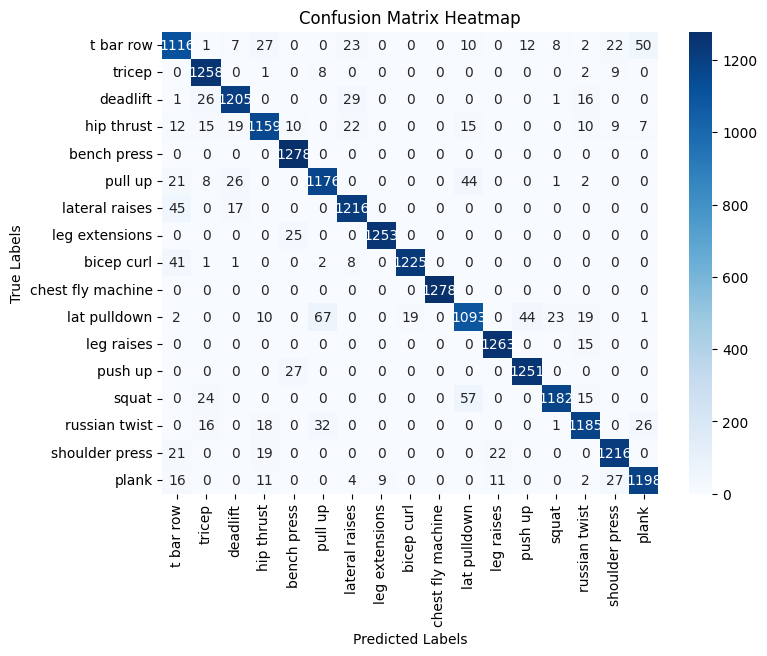

Best Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 200, 100), 'max_iter': 200}
Accuracy: 94.59633618705698 %
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      1278
           1       0.93      0.98      0.96      1278
           2       0.95      0.94      0.94      1278
           3       0.93      0.91      0.92      1278
           4       0.95      1.00      0.98      1278
           5       0.92      0.92      0.92      1278
           6       0.93      0.95      0.94      1278
           7       0.99      0.98      0.99      1278
           8       0.98      0.96      0.97      1278
           9       1.00      1.00      1.00      1278
          10       0.90      0.86      0.88      1278
          11       0.97      0.99      0.98      1278
          12       0.96      0.98      0.97      1278
          13       0.97      0.92      0.95      1278
          14       0.93

In [32]:
mlp_model = MLPClassifier(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

mlp_model = train_model(mlp_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

In [33]:
with open(os.getcwd() + "/models/mlp_workout_classifier.pkl", 'wb') as f:
    print(type(mlp_model))
    pickle.dump(mlp_model, f)

<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>


In [34]:
with open(os.getcwd() + "/models/mlp_workout_classifier.pkl", 'rb') as f:
    mlp_model = pickle.load(f)

**Multilayer Perceptron with feature engineering**

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=400; total time=  45.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=200; total time=  47.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=200; total time=  47.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=800; total time=  48.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=400; total time=  49.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=800; total time=  49.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=400; total time=  50.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=800; total time=  51.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=200; total time=  52.2s
[C

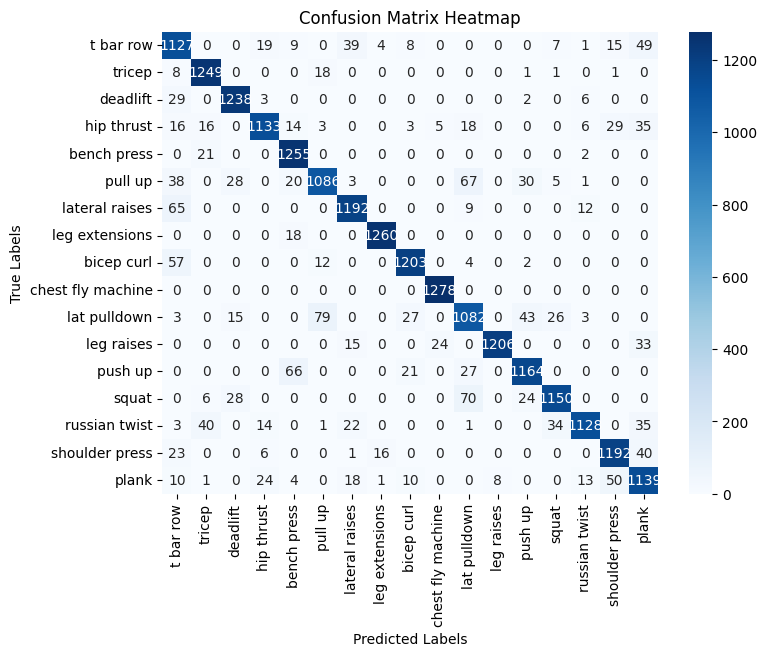

Best Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 200, 100), 'max_iter': 200}
Accuracy: 92.43302954984811 %
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      1278
           1       0.94      0.98      0.96      1278
           2       0.95      0.97      0.96      1278
           3       0.94      0.89      0.91      1278
           4       0.91      0.98      0.94      1278
           5       0.91      0.85      0.88      1278
           6       0.92      0.93      0.93      1278
           7       0.98      0.99      0.98      1278
           8       0.95      0.94      0.94      1278
           9       0.98      1.00      0.99      1278
          10       0.85      0.85      0.85      1278
          11       0.99      0.94      0.97      1278
          12       0.92      0.91      0.92      1278
          13       0.94      0.90      0.92      1278
          14       0.96

In [35]:
mlp_model = MLPClassifier(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feature_eng)
X_test_scaled = scaler.fit_transform(X_test_feature_eng)

mlp_feat_eng_model = train_model(mlp_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

In [36]:
with open(os.getcwd() + "/models/mlp_feat_eng_workout_classifier.pkl", 'wb') as f:
    print(type(mlp_feat_eng_model))
    pickle.dump(mlp_feat_eng_model, f)

<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>


In [37]:
with open(os.getcwd() + "/models/mlp_feat_eng_workout_classifier.pkl", 'rb') as f:
    mlp_feat_eng_model = pickle.load(f)

**Support Vector Machines**

In [41]:
param_grid = {
    'C': [10],  
    'kernel': ['rbf'],  
    'gamma': ['auto'],  
}

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=  27.1s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=  27.4s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=  27.6s


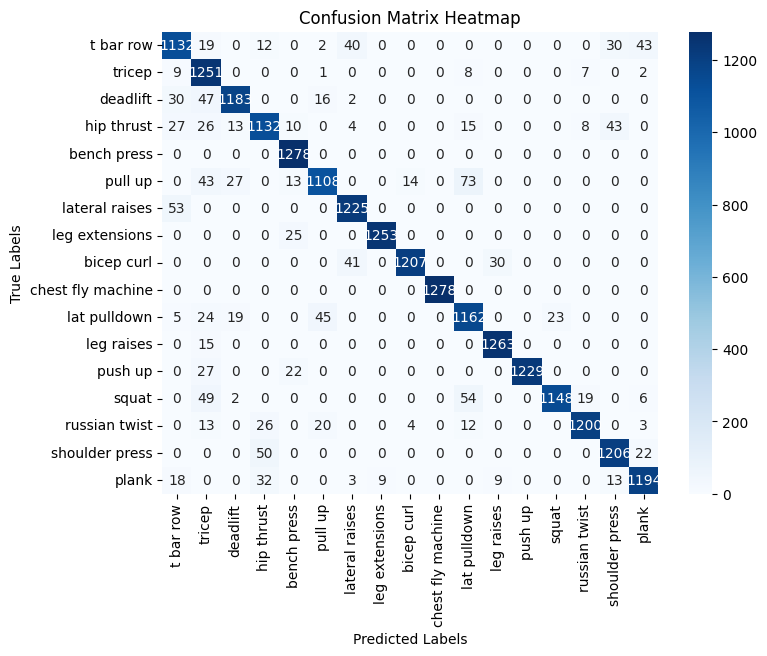

Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 94.12224983890269 %
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1278
           1       0.83      0.98      0.90      1278
           2       0.95      0.93      0.94      1278
           3       0.90      0.89      0.89      1278
           4       0.95      1.00      0.97      1278
           5       0.93      0.87      0.90      1278
           6       0.93      0.96      0.94      1278
           7       0.99      0.98      0.99      1278
           8       0.99      0.94      0.96      1278
           9       1.00      1.00      1.00      1278
          10       0.88      0.91      0.89      1278
          11       0.97      0.99      0.98      1278
          12       1.00      0.96      0.98      1278
          13       0.98      0.90      0.94      1278
          14       0.97      0.94      0.96      1278
          15       0

In [42]:
svc_model = SVC(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

svc_model = train_model(svc_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

In [ ]:
with open(os.getcwd() + "/models/svc_workout_classifier.pkl", 'wb') as f:
    print(type(svc_model))
    pickle.dump(svc_model, f)

<class 'sklearn.svm._classes.SVC'>


In [ ]:
with open(os.getcwd() + "/models/svc_workout_classifier.pkl", 'rb') as f:
    svc_model = pickle.load(f)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  30.6s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  37.9s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  38.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  38.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  38.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  38.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  47.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.0min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 1.0min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.0min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 1.0min
[CV] END ......................C=0.1, gamma=auto

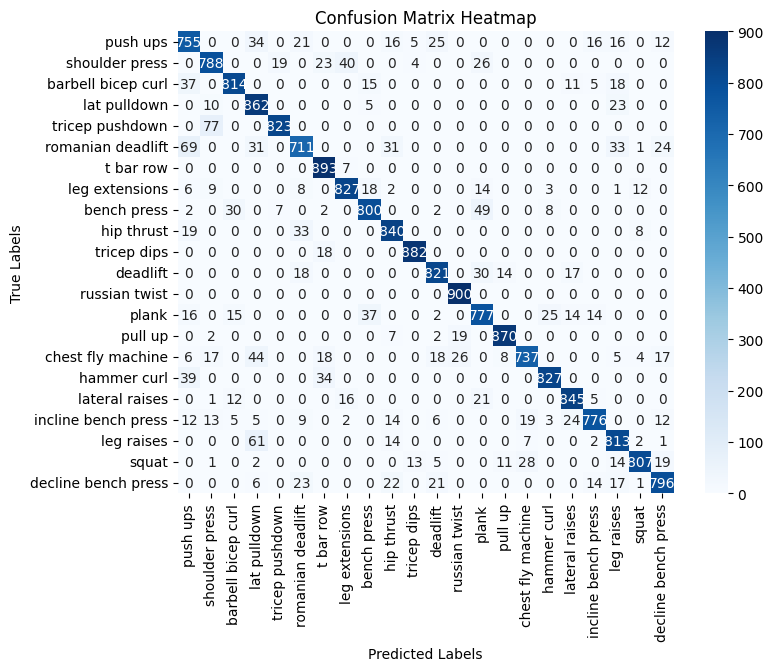

Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 90.72727272727272 %
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81       900
           1       0.86      0.88      0.87       900
           2       0.93      0.90      0.92       900
           3       0.82      0.96      0.89       900
           4       0.97      0.91      0.94       900
           5       0.86      0.79      0.83       900
           6       0.90      0.99      0.95       900
           7       0.93      0.92      0.92       900
           8       0.91      0.89      0.90       900
           9       0.89      0.93      0.91       900
          10       0.98      0.98      0.98       900
          11       0.91      0.91      0.91       900
          12       0.95      1.00      0.98       900
          13       0.85      0.86      0.86       900
          14       0.96      0.97      0.97       900
          15       0

In [ ]:
svc_model = SVC(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feature_eng)
X_test_scaled = scaler.fit_transform(X_test_feature_eng)

svc_feat_eng_model = train_model(svc_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

In [ ]:
with open(os.getcwd() + "/models/svc_feat_eng_workout_classifier.pkl", 'wb') as f:
    print(type(svc_feat_eng_model))
    pickle.dump(svc_feat_eng_model, f)

<class 'sklearn.svm._classes.SVC'>


In [ ]:
with open(os.getcwd() + "/models/svc_feat_eng_workout_classifier.pkl", 'rb') as f:
    svc_model = pickle.load(f)

**Upsampling the training dataset, then comparing the results to above**
- Applying SMOTE to make sure all classes are evenly distributed